In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install dgl -f https://data.dgl.ai/wheels/repo.html
#!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html
#!pip install dive-into-graphs
#!pip install pydig

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 23.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from termcolor import colored
from torch._C import dtype

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch_geometric.nn as gnn
import torch.nn.functional as F
from torch.nn import Linear
from sklearn.model_selection import train_test_split
import numpy as np
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.data.batch import Batch
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from typing import Callable, Union, Tuple
from torch_sparse import SparseTensor
from sklearn import metrics
from copy import deepcopy
from scipy.spatial.distance import hamming
from time import perf_counter
import csv
from torch.nn.modules import activation
import random
import pandas
import statistics


from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
import tensorflow as tf

#. DGL
#import dgl
#import dgl.function as fn
#from dgl.data import GINDataset
#from dgl.nn import GNNExplainer as GNNExplainer_DGL
#from dgl.dataloading import GraphDataLoader
#from dgl.nn import AvgPooling

#. DIG
#from dig.xgraph.dataset import SynGraphDataset
#from dig.xgraph.method import PGExplainer
#from dig.xgraph.utils.compatibility import compatible_state_dict
#from dig.xgraph.method.subgraphx import PlotUtils
#from dig.xgraph.method.subgraphx import MCTS
#from torch_geometric.utils import to_networkx
#from dig.xgraph.method import GNNExplainer as GNNExplainer_DIG
#from dig.xgraph.models import GCN_2l
#from dig.xgraph.models import GlobalMeanPool

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Explainability_name = 'ExcitationBP'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6
classifier_bias = True
Model_name = "GCN_plus_GAP"
DataSet_name = "MUTAG"
normalize_coeff = 100
File_Name = Model_name + " " + Explainability_name + " " + Task_name + " " + DataSet_name + " "

In [5]:
#dataset = SynGraphDataset('./datasets', 'BA_shapes')
dataset = TUDataset(root='data/TUDataset', name='MUTAG')
#dataset = GINDataset('MUTAG', self_loop=False)


Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


In [6]:
print("Number of Graphs: ", len(dataset))
print("Number of Node Features: ", dataset.num_node_features)
print("Number of Edge Features: ", dataset.num_edge_features)
#print("Number of Node Features: ", dataset.num_node_attributes)
#print("Number of Node Features: ", dataset.num_edge_attributes)
print("Number of Classes: ", dataset.num_classes)
count=0
for i in range(len(dataset)):
    count = count + len(dataset[i].edge_index[0])
print("Number of Edges: ", count)
data = dataset[0]
print(data)
#print(dataset.labels)

Number of Graphs:  188
Number of Node Features:  7
Number of Edge Features:  4
Number of Classes:  2
Number of Edges:  7442
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [7]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
    read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
    read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]


In [8]:
torch.manual_seed(123456)

#train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=100, shuffle=True)
#train_dataset = dataset[:150]
#test_dataset = dataset[150:]

train_dataset = []
test_dataset = []
for index in read_training_list_indexes:
    train_dataset.append(dataset[index])
for index in read_test_list_indexes:
    test_dataset.append(dataset[index])

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [9]:
print("Number of Training Graphs: ", len(train_dataset))
print("Number of Test Graphs: ", len(test_dataset))

count=0
for i in range(len(train_dataset)):
    count = count + len(train_dataset[i].edge_index[0])
print("Number of Edges in TrainingSet: ", count)
count=0
for i in range(len(test_dataset)):
    count = count + len(test_dataset[i].edge_index[0])
print("Number of Edges in TestSet: ", count)

Number of Training Graphs:  150
Number of Test Graphs:  38
Number of Edges in TrainingSet:  6064
Number of Edges in TestSet:  1378


In [10]:
g = train_dataset[0]
print(g.y)

tensor([1])


## **Batching Data by DataLoader**

In [11]:
BATCH_SIZE = 64

torch.manual_seed(123456)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
print(train_dataset[0])
#print(train_dataset[0][0])
#print(train_dataset[0][0])
print(train_dataset[0])
######print(GCN_Model(dataset[0].x, dataset[0].edge_index))

Data(edge_index=[2, 60], x=[26, 7], edge_attr=[60, 4], y=[1])
Data(edge_index=[2, 60], x=[26, 7], edge_attr=[60, 4], y=[1])


In [13]:
print(train_loader.batch_size)
batch = next(iter(train_loader))
print(batch.y)
print(len(train_loader))

64
tensor([1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])
3


In [14]:
for batch in train_loader:
    print(batch.y)

tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1])
tensor([0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1])


In [15]:
feat_size = train_dataset[0].x.shape[1]
print(feat_size)
#DGL_Model = Graph_Model(feat_size, dataset.gclasses)

7


# **GCN MODEL**

In [16]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)
import GCN_plus_GAP as Graph_Network
#import DGCNN as dgcnn_model
#GNN_Model = dgcnn_model.DGCNN_Model(GNN_layers=[32, 32, 32, 7], num_classes=2, mlp_act_fun='ReLu', dgcnn_act_fun='tanh', mlp_dropout_rate=0.5, Weight_Initializer=3, Bias=False, dgcnn_k=20, node_feat_size=7, hid_channels=[16,32], conv1d_kernels=[2,5], ffn_layer_size=128, strides=[2,1])
GNN_Model = Graph_Network.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph', input_dim=7, hidden_dim=7, output_dim=2,
                                       num_hid_layers=2, Bias=classifier_bias, act_fun='ReLu', Weight_Initializer=1,
                                       dropout_rate=classifier_dropout)

GCN_plus_GAP Input_Dimension: 7
GCN_plus_GAP Hidden_Dimension: 7
GCN_plus_GAP Output_Dimension: 2
GCN_plus_GAP Number_of_Hidden_Layers: 2
eLu is Selected.
GCN_plus_GAP(
  (GConvs): ModuleList(
    (0-1): 2 x GCNConv(7, 7)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (readout): GlobalMeanPool()
  (ffn): Linear(in_features=7, out_features=2, bias=True)
)
GCN_plus_GAP Input_Dimension: 7
GCN_plus_GAP Hidden_Dimension: 7
GCN_plus_GAP Output_Dimension: 2
GCN_plus_GAP Number_of_Hidden_Layers: 2
eLu is Selected.


In [17]:
GNN_Model_Optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [18]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch


In [20]:
def loading_model(load_index):
    GNN_Model = Graph_Network.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph', input_dim=7, hidden_dim=7, output_dim=2,
                                           num_hid_layers=2, Bias=classifier_bias, act_fun='ReLu', Weight_Initializer=1,
                                           dropout_rate=classifier_dropout)
    GNN_Model_Optimizer = torch.optim.Adam(params = GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)
    checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")
    GNN_Model.load_state_dict(checkpoint['model_state_dict'])
    GNN_Model.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']


    return GNN_Model, GNN_Model_Optimizer, epoch

In [21]:
def visualize_losses(gcn_losses, epoch_history):
    gcn_losses_list = torch.stack(gcn_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("`GCN Model Loss in Epoch: " + str(epoch_history))
    ax.plot(gcn_losses_list, color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()

# **Traning Configurations**

In [22]:
def train_step():
    GNN_Model_loss_batch = []
    LRP_Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model.zero_grad()
    for batch_of_graphs in train_loader:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
        pred = soft.argmax(dim=1)
        LRP_Pred_Labels.extend(pred.detach().tolist())
        Real_Labels.extend(batch_of_graphs.y.detach().tolist())

        batch_loss = loss_calculations(soft, batch_of_graphs.y)
        GNN_Model_loss_batch.append(batch_loss)

        batch_loss.backward()
        GNN_Model_Optimizer.step()

    return torch.mean(torch.tensor(GNN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, LRP_Pred_Labels)

In [23]:
LOSS_Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [24]:
ExcitationBP_Model_training_time_per_epoch = []
ExcitationBP_Model_training_Acc_per_epoch = []
def train(EPOCHS, load_index):
    GNN_Model_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        start_generation = perf_counter()
        GNN_Model_training_loss, training_acc = train_step()
        ExcitationBP_Model_training_time_per_epoch.append(perf_counter() - start_generation)
        ExcitationBP_Model_training_Acc_per_epoch.append(training_acc)
        print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GNN_Model_training_loss:.4f}')

        GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)

        #break

        if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
            visualize_losses(GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
        if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
            torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_Optimizer.state_dict(), 'loss': GNN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")


    #return model_loss




Epoch: 001, ExcitationBP Model Loss: 0.7287
Epoch: 002, ExcitationBP Model Loss: 0.7282
Epoch: 003, ExcitationBP Model Loss: 0.7209
Epoch: 004, ExcitationBP Model Loss: 0.7180
Epoch: 005, ExcitationBP Model Loss: 0.7118
Epoch: 006, ExcitationBP Model Loss: 0.7038
Epoch: 007, ExcitationBP Model Loss: 0.7019
Epoch: 008, ExcitationBP Model Loss: 0.6924
Epoch: 009, ExcitationBP Model Loss: 0.6920
Epoch: 010, ExcitationBP Model Loss: 0.6846
Epoch: 011, ExcitationBP Model Loss: 0.6789
Epoch: 012, ExcitationBP Model Loss: 0.6769
Epoch: 013, ExcitationBP Model Loss: 0.6713
Epoch: 014, ExcitationBP Model Loss: 0.6660
Epoch: 015, ExcitationBP Model Loss: 0.6601
Epoch: 016, ExcitationBP Model Loss: 0.6572
Epoch: 017, ExcitationBP Model Loss: 0.6534
Epoch: 018, ExcitationBP Model Loss: 0.6640
Epoch: 019, ExcitationBP Model Loss: 0.6476
Epoch: 020, ExcitationBP Model Loss: 0.6518
Epoch: 021, ExcitationBP Model Loss: 0.6504
Epoch: 022, ExcitationBP Model Loss: 0.6407
Epoch: 023, ExcitationBP Model L

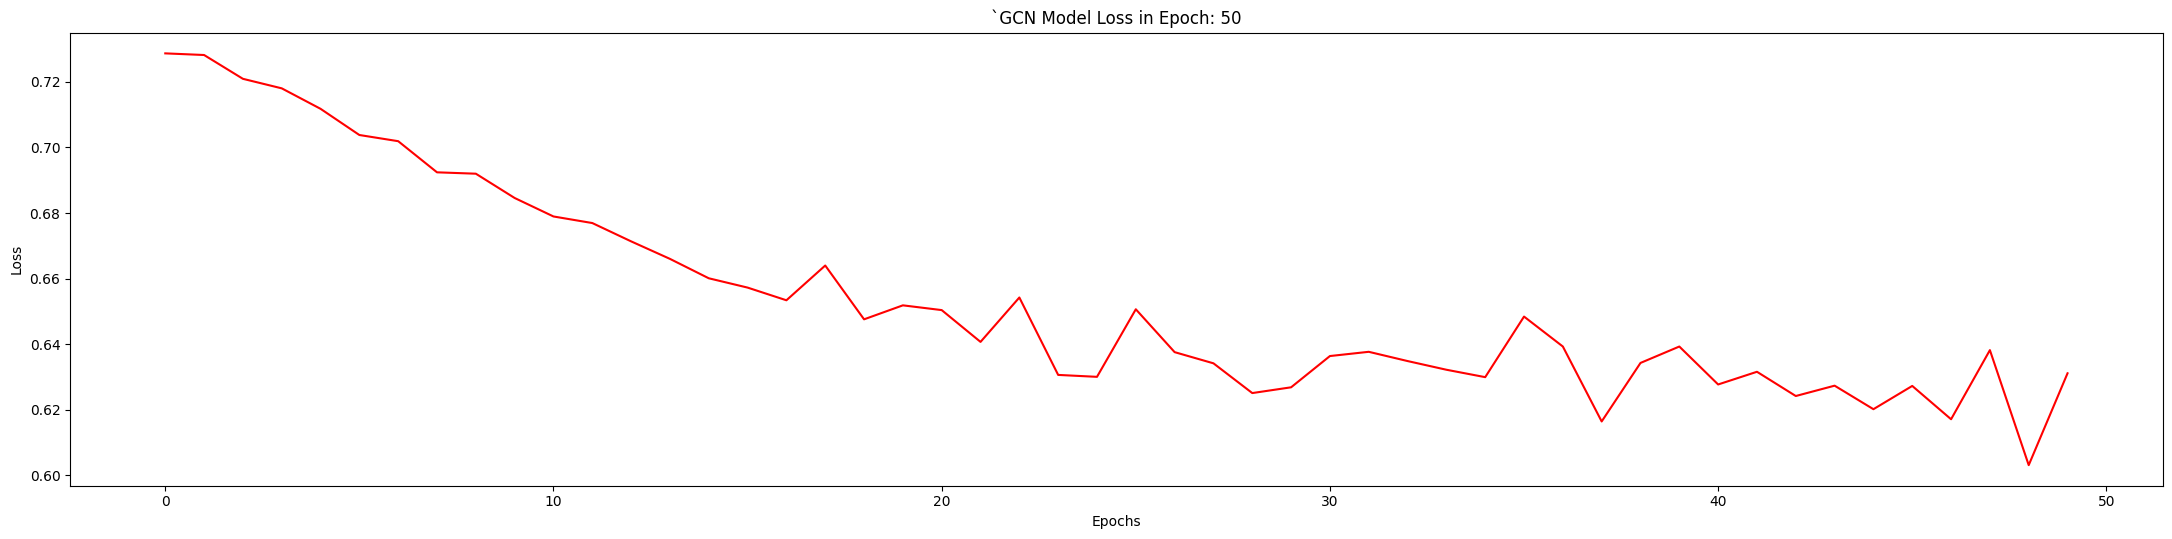

Epoch: 051, ExcitationBP Model Loss: 0.6130
Epoch: 052, ExcitationBP Model Loss: 0.6168
Epoch: 053, ExcitationBP Model Loss: 0.6192
Epoch: 054, ExcitationBP Model Loss: 0.6293
Epoch: 055, ExcitationBP Model Loss: 0.6110
Epoch: 056, ExcitationBP Model Loss: 0.6427
Epoch: 057, ExcitationBP Model Loss: 0.6354
Epoch: 058, ExcitationBP Model Loss: 0.6293
Epoch: 059, ExcitationBP Model Loss: 0.6465
Epoch: 060, ExcitationBP Model Loss: 0.6371
Epoch: 061, ExcitationBP Model Loss: 0.6243
Epoch: 062, ExcitationBP Model Loss: 0.6426
Epoch: 063, ExcitationBP Model Loss: 0.6147
Epoch: 064, ExcitationBP Model Loss: 0.6237
Epoch: 065, ExcitationBP Model Loss: 0.6365
Epoch: 066, ExcitationBP Model Loss: 0.6063
Epoch: 067, ExcitationBP Model Loss: 0.6154
Epoch: 068, ExcitationBP Model Loss: 0.6237
Epoch: 069, ExcitationBP Model Loss: 0.6371
Epoch: 070, ExcitationBP Model Loss: 0.6342
Epoch: 071, ExcitationBP Model Loss: 0.6281
Epoch: 072, ExcitationBP Model Loss: 0.6213
Epoch: 073, ExcitationBP Model L

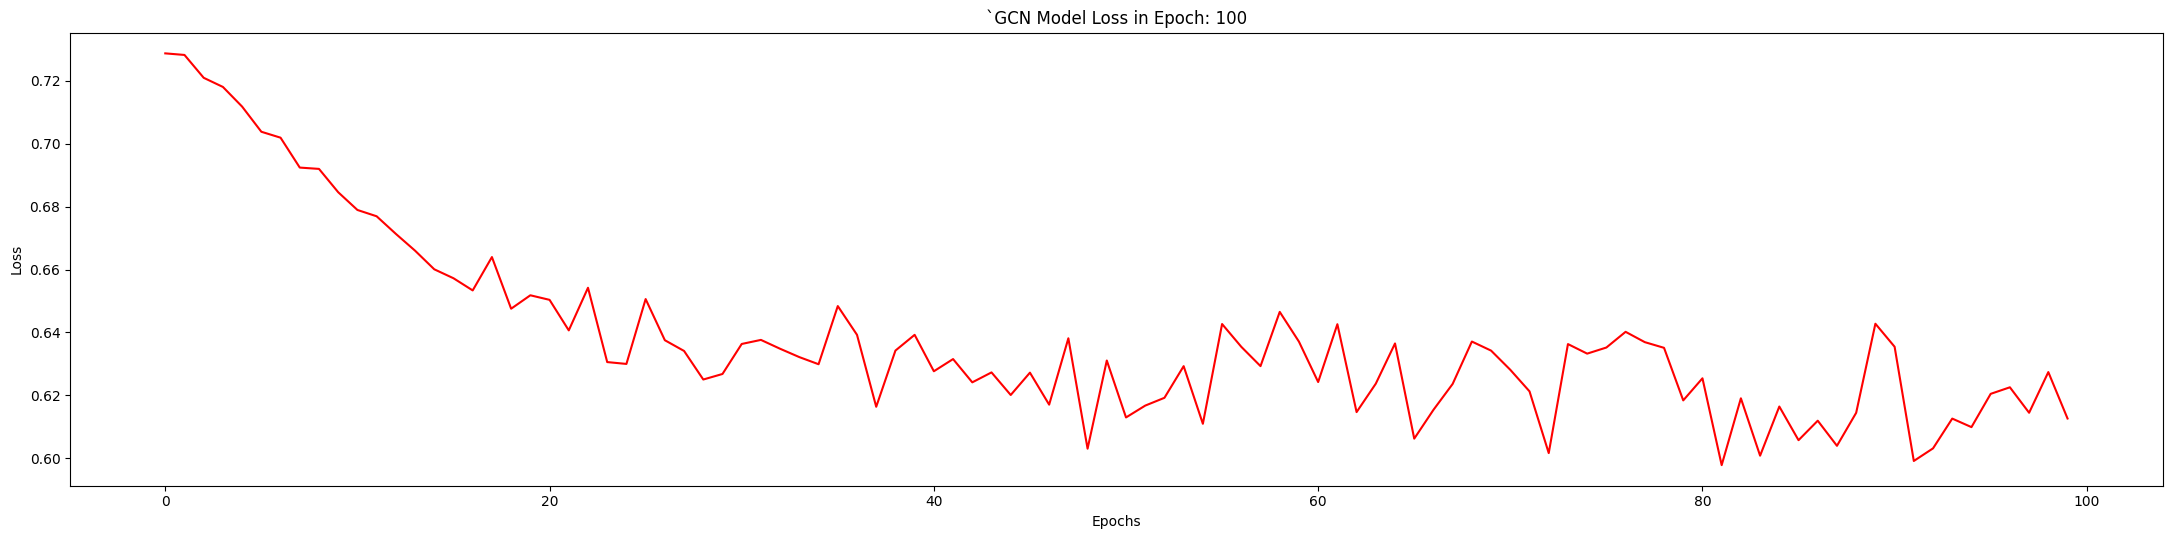

Epoch: 101, ExcitationBP Model Loss: 0.6203
Epoch: 102, ExcitationBP Model Loss: 0.6365
Epoch: 103, ExcitationBP Model Loss: 0.6084
Epoch: 104, ExcitationBP Model Loss: 0.6209
Epoch: 105, ExcitationBP Model Loss: 0.6298
Epoch: 106, ExcitationBP Model Loss: 0.6122
Epoch: 107, ExcitationBP Model Loss: 0.6122
Epoch: 108, ExcitationBP Model Loss: 0.6361
Epoch: 109, ExcitationBP Model Loss: 0.6202
Epoch: 110, ExcitationBP Model Loss: 0.6185
Epoch: 111, ExcitationBP Model Loss: 0.6143
Epoch: 112, ExcitationBP Model Loss: 0.6102
Epoch: 113, ExcitationBP Model Loss: 0.6045
Epoch: 114, ExcitationBP Model Loss: 0.6070
Epoch: 115, ExcitationBP Model Loss: 0.5872
Epoch: 116, ExcitationBP Model Loss: 0.6226
Epoch: 117, ExcitationBP Model Loss: 0.6038
Epoch: 118, ExcitationBP Model Loss: 0.6310
Epoch: 119, ExcitationBP Model Loss: 0.6090
Epoch: 120, ExcitationBP Model Loss: 0.6088
Epoch: 121, ExcitationBP Model Loss: 0.6129
Epoch: 122, ExcitationBP Model Loss: 0.6170
Epoch: 123, ExcitationBP Model L

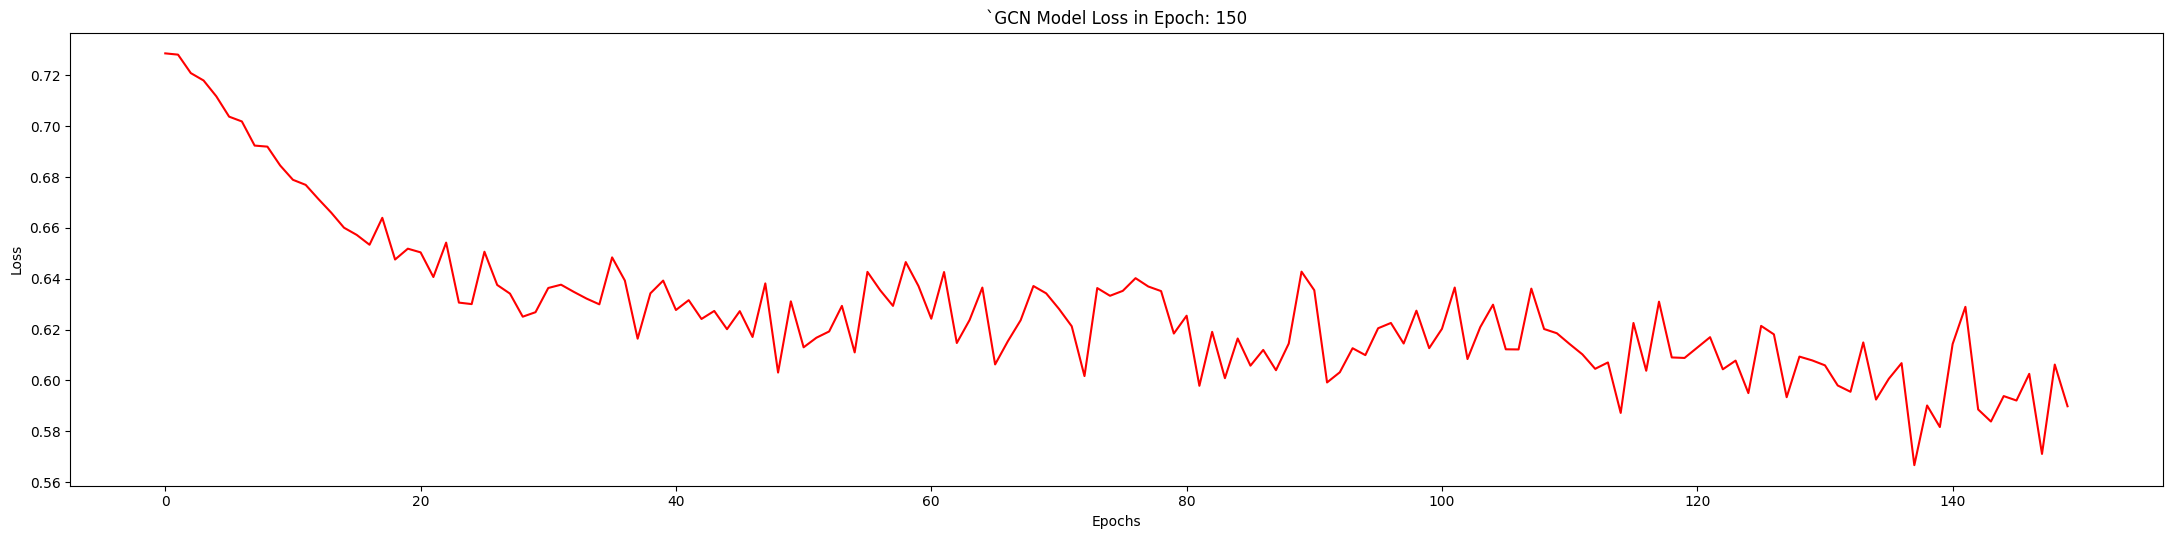

Epoch: 151, ExcitationBP Model Loss: 0.6027
Epoch: 152, ExcitationBP Model Loss: 0.5834
Epoch: 153, ExcitationBP Model Loss: 0.5907
Epoch: 154, ExcitationBP Model Loss: 0.5866
Epoch: 155, ExcitationBP Model Loss: 0.5849
Epoch: 156, ExcitationBP Model Loss: 0.5967
Epoch: 157, ExcitationBP Model Loss: 0.6065
Epoch: 158, ExcitationBP Model Loss: 0.5865
Epoch: 159, ExcitationBP Model Loss: 0.5958
Epoch: 160, ExcitationBP Model Loss: 0.6234
Epoch: 161, ExcitationBP Model Loss: 0.6065
Epoch: 162, ExcitationBP Model Loss: 0.5839
Epoch: 163, ExcitationBP Model Loss: 0.5764
Epoch: 164, ExcitationBP Model Loss: 0.5864
Epoch: 165, ExcitationBP Model Loss: 0.5767
Epoch: 166, ExcitationBP Model Loss: 0.5800
Epoch: 167, ExcitationBP Model Loss: 0.5763
Epoch: 168, ExcitationBP Model Loss: 0.5811
Epoch: 169, ExcitationBP Model Loss: 0.5774
Epoch: 170, ExcitationBP Model Loss: 0.5720
Epoch: 171, ExcitationBP Model Loss: 0.5969
Epoch: 172, ExcitationBP Model Loss: 0.5929
Epoch: 173, ExcitationBP Model L

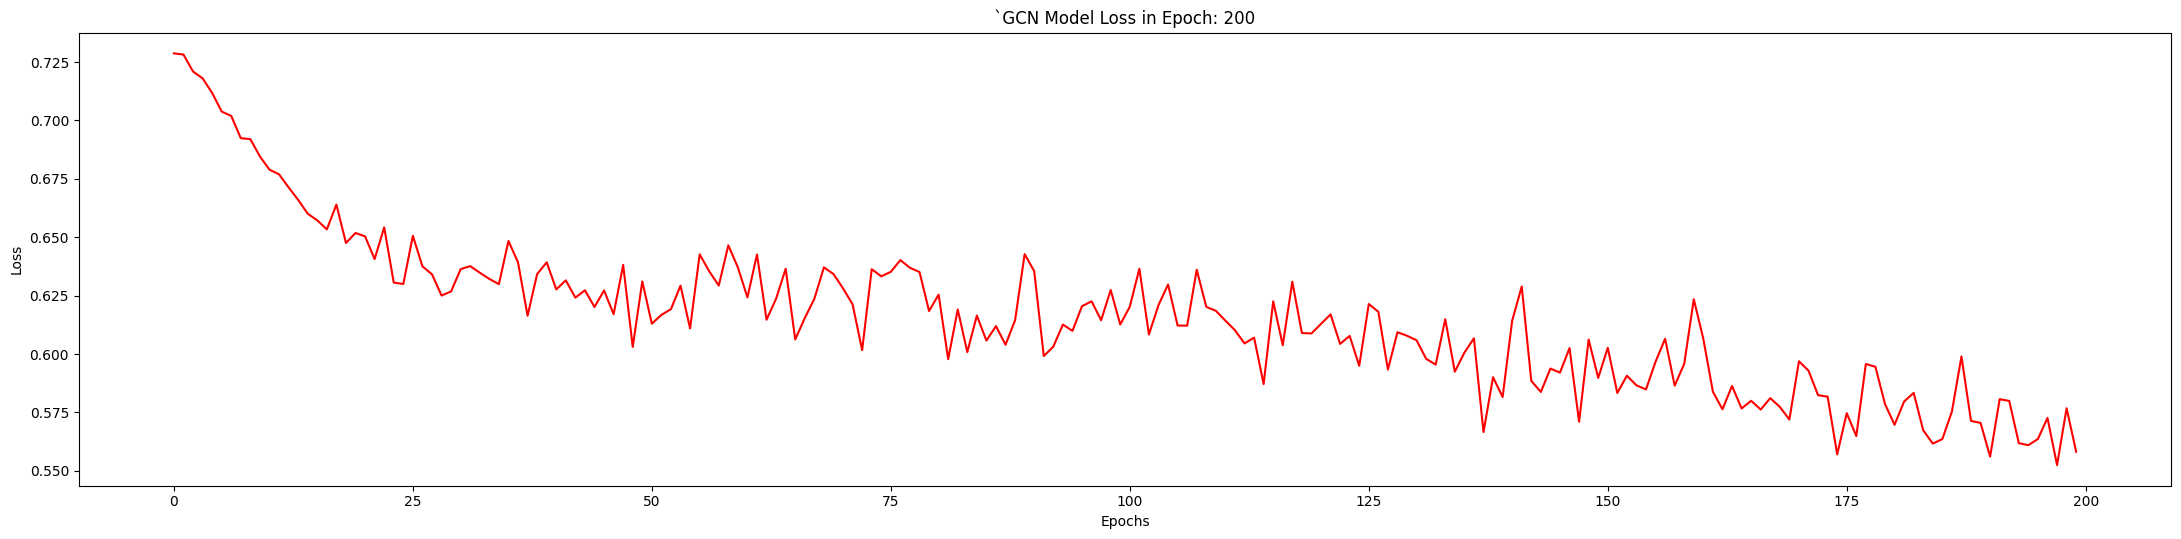

Epoch: 201, ExcitationBP Model Loss: 0.5832
Epoch: 202, ExcitationBP Model Loss: 0.5790
Epoch: 203, ExcitationBP Model Loss: 0.5480
Epoch: 204, ExcitationBP Model Loss: 0.5757
Epoch: 205, ExcitationBP Model Loss: 0.5557
Epoch: 206, ExcitationBP Model Loss: 0.5519
Epoch: 207, ExcitationBP Model Loss: 0.5669
Epoch: 208, ExcitationBP Model Loss: 0.5708
Epoch: 209, ExcitationBP Model Loss: 0.5713
Epoch: 210, ExcitationBP Model Loss: 0.5554
Epoch: 211, ExcitationBP Model Loss: 0.5803
Epoch: 212, ExcitationBP Model Loss: 0.5444
Epoch: 213, ExcitationBP Model Loss: 0.5496
Epoch: 214, ExcitationBP Model Loss: 0.5596
Epoch: 215, ExcitationBP Model Loss: 0.5578
Epoch: 216, ExcitationBP Model Loss: 0.5600
Epoch: 217, ExcitationBP Model Loss: 0.5553
Epoch: 218, ExcitationBP Model Loss: 0.5740
Epoch: 219, ExcitationBP Model Loss: 0.5583
Epoch: 220, ExcitationBP Model Loss: 0.5622
Epoch: 221, ExcitationBP Model Loss: 0.5471
Epoch: 222, ExcitationBP Model Loss: 0.5560
Epoch: 223, ExcitationBP Model L

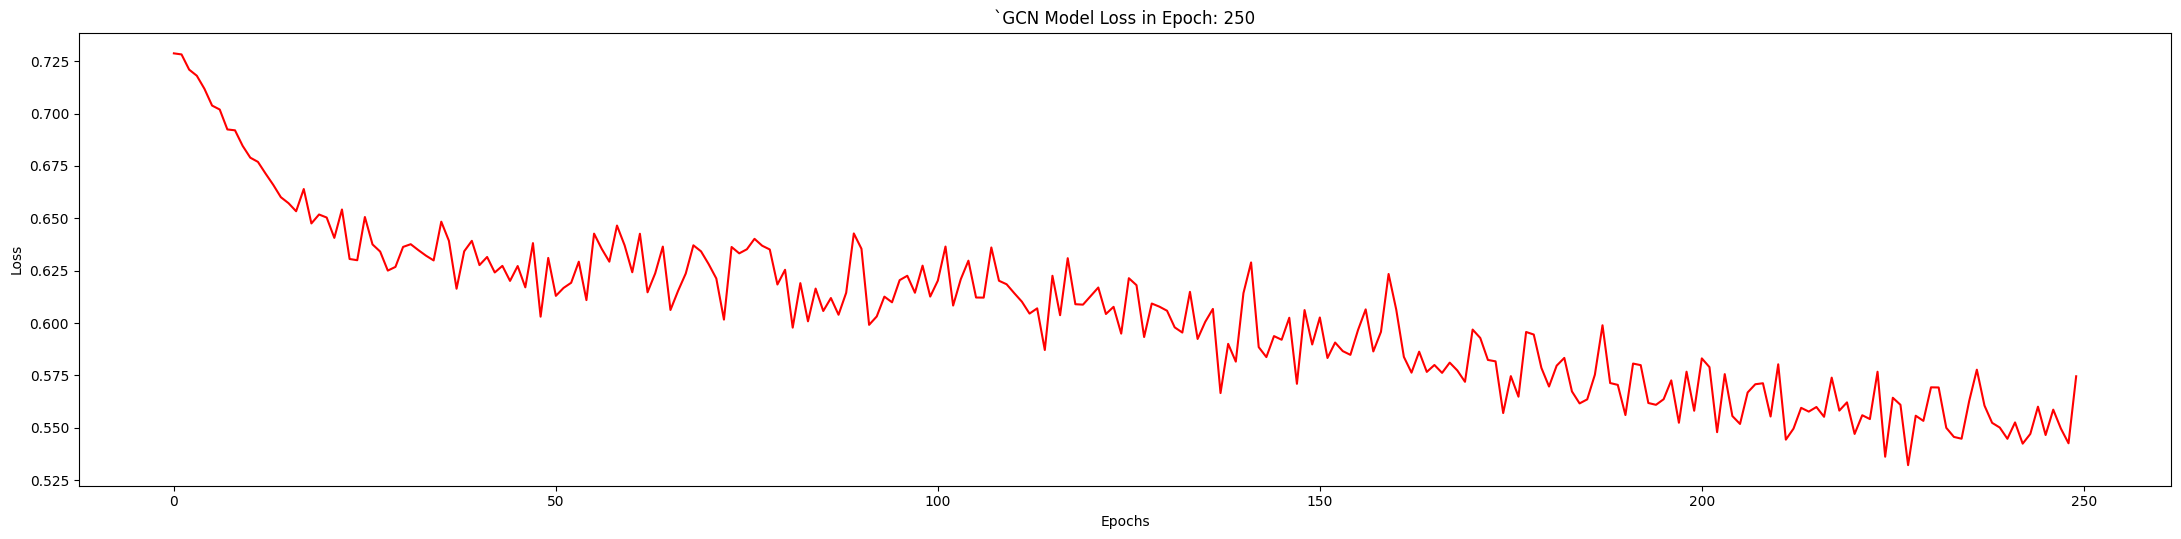

Epoch: 251, ExcitationBP Model Loss: 0.5669
Epoch: 252, ExcitationBP Model Loss: 0.5579
Epoch: 253, ExcitationBP Model Loss: 0.5750
Epoch: 254, ExcitationBP Model Loss: 0.5635
Epoch: 255, ExcitationBP Model Loss: 0.5593
Epoch: 256, ExcitationBP Model Loss: 0.5412
Epoch: 257, ExcitationBP Model Loss: 0.5361
Epoch: 258, ExcitationBP Model Loss: 0.5367
Epoch: 259, ExcitationBP Model Loss: 0.5581
Epoch: 260, ExcitationBP Model Loss: 0.5406
Epoch: 261, ExcitationBP Model Loss: 0.5476
Epoch: 262, ExcitationBP Model Loss: 0.5470
Epoch: 263, ExcitationBP Model Loss: 0.5696
Epoch: 264, ExcitationBP Model Loss: 0.5499
Epoch: 265, ExcitationBP Model Loss: 0.5253
Epoch: 266, ExcitationBP Model Loss: 0.5313
Epoch: 267, ExcitationBP Model Loss: 0.5618
Epoch: 268, ExcitationBP Model Loss: 0.5438
Epoch: 269, ExcitationBP Model Loss: 0.5419
Epoch: 270, ExcitationBP Model Loss: 0.5415
Epoch: 271, ExcitationBP Model Loss: 0.5235
Epoch: 272, ExcitationBP Model Loss: 0.5283
Epoch: 273, ExcitationBP Model L

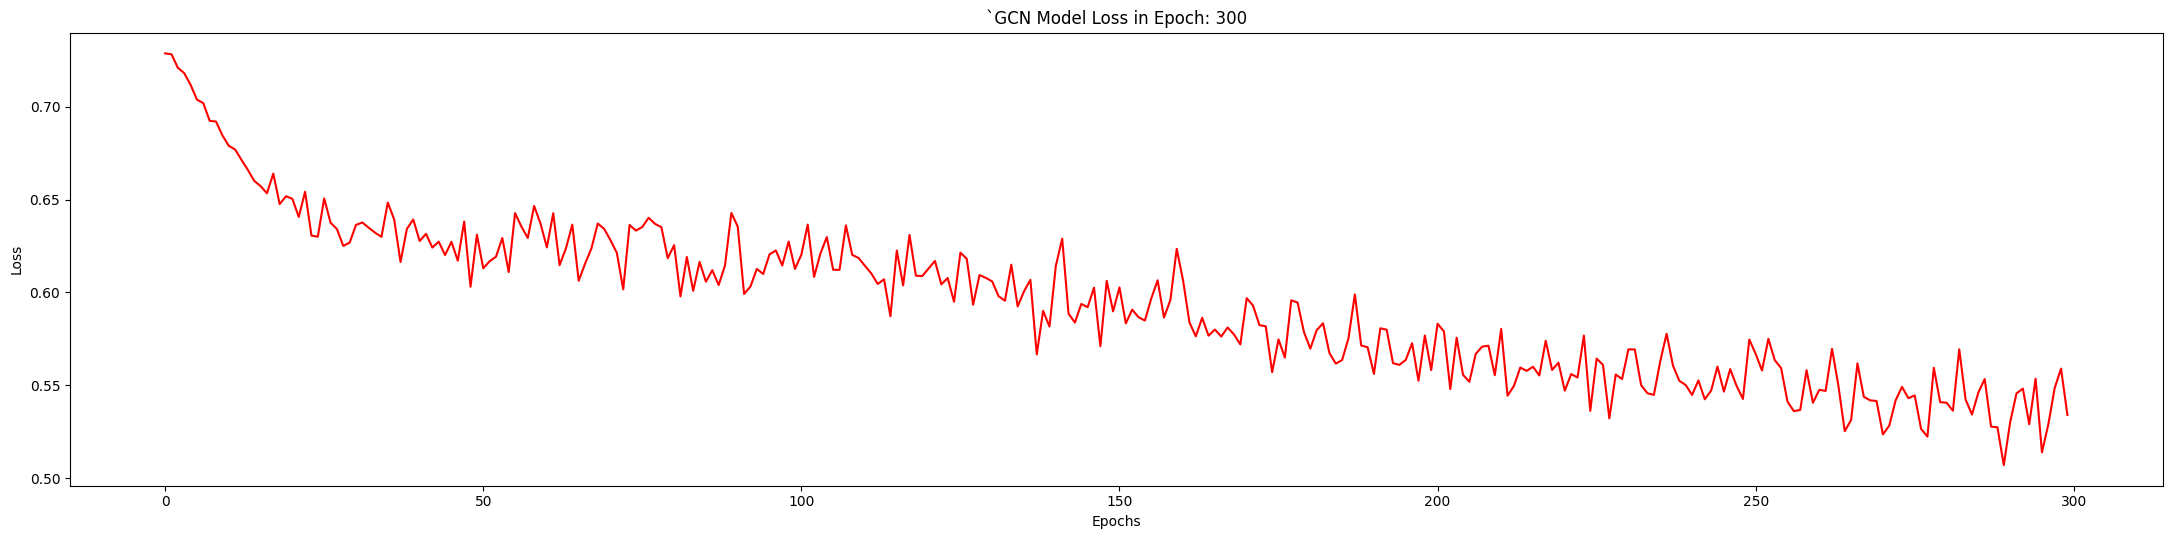

In [25]:
EPOCHS = 300
load_index = 0
if load_index != 0:
    GNN_Model, GNN_Model_Optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [ ]:

def GNN_Model_test(test_loader):
    predictions = []
    GNN_Model.eval()

    correct = 0
    for batch_of_graphs in test_loader:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
        GNN_Model_test_pred = soft.argmax(dim=1)
        predictions.append(GNN_Model_test_pred)

        correct += int((GNN_Model_test_pred == batch_of_graphs.y).sum())

    return correct / len(test_dataset), predictions[0].detach().tolist()

In [ ]:
GNN_Model_test_acc, predictions = GNN_Model_test(test_loader)
print(f'Test Accuracy: {GNN_Model_test_acc:.4f}')

Test Accuracy: 0.5526


In [ ]:
def instance_time(test_dataset):
    instance_based_time = []
    GNN_Model.eval()
    correct = 0
    for batched_data in test_dataset:
        start_generation = perf_counter()
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batched_data)
        CAM_test_pred = soft.argmax(dim=1)
        consumed_time = perf_counter() - start_generation
        instance_based_time.append(consumed_time)
    return instance_based_time

In [ ]:
samples_time = instance_time(test_dataset)
print(f'Test Instance based Time: {samples_time}')

Test Instance based Time: [0.0028752390000192918, 0.0017651100000080078, 0.00192729899998767, 0.0018349499999885666, 0.001579718999977331, 0.0014667100000167466, 0.0009402199999897221, 0.000823179999997592, 0.0008265300000118714, 0.0008416800000077274, 0.0008418900000037866, 0.000986890000007179, 0.0008303200000057132, 0.000798129999992625, 0.0007945300000073985, 0.0007279390000007879, 0.0009193690000017796, 0.0007864300000051117, 0.0007482700000025488, 0.000796879999995781, 0.0007595589999880303, 0.0007898300000022118, 0.0007457600000009279, 0.0007453599999962535, 0.0007084599999984675, 0.0007598600000164879, 0.0007544700000039484, 0.0007576299999811908, 0.0006986600000118415, 0.0007207090000065364, 0.0007297000000221487, 0.001934739999995827, 0.001069838999995909, 0.0009464790000208723, 0.000934639999996989, 0.0008135799999990923, 0.000828909000006206, 0.0008330299999954605]


In [ ]:
GNN_Model.eval()

Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft  = GNN_Model(dataset[0])


In [ ]:
print(predictions)
real_labels = []
for graph in test_dataset:
    real_labels.append(graph.y.detach().tolist()[0])
print(real_labels)

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]


In [ ]:
Auc_Roc = metrics.roc_auc_score(real_labels, predictions)
precision, recall, thresholds = metrics.precision_recall_curve(real_labels, predictions)
Auc_Prc = metrics.auc(y=precision, x=recall)
Acc = metrics.accuracy_score(real_labels, predictions, normalize=True)
Acc2 = metrics.accuracy_score(real_labels, predictions, normalize=False)
print("Auc_Roc: ", Auc_Roc, "Auc_Prc: ", Auc_Prc, "Acc: ", Acc, "Acc2: ", Acc2)

Auc_Roc:  0.48214285714285715 Auc_Prc:  0.7642921960072595 Acc:  0.5526315789473685 Acc2:  21


## **Instance Specific Time**

In [ ]:
def instance_time(test_dataset):
    instance_based_time = []
    GNN_Model.eval()
    correct = 0
    for batched_data in test_dataset:
        start_generation = perf_counter()
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batched_data)
        CAM_test_pred = soft.argmax(dim=1)
        consumed_time = perf_counter() - start_generation
        instance_based_time.append(consumed_time)
    return instance_based_time

In [ ]:
times = instance_time(test_dataset)
print(f'Test Instance based Time: {times}')

Test Instance based Time: [0.0031511689999774717, 0.0024957200000130797, 0.001337528999982851, 0.0008126099999969938, 0.0008821700000112287, 0.0008336790000100791, 0.0008404599999778384, 0.0007758600000045135, 0.0007690299999865147, 0.0007402700000227469, 0.0007629290000181754, 0.0007542689999979757, 0.0007695599999806291, 0.0007230100000015227, 0.0007739889999811567, 0.0007427890000144544, 0.0007546300000171868, 0.0007263800000032461, 0.0007725400000140326, 0.0008567399999890313, 0.0008082599999852391, 0.0007975200000203131, 0.000742440000010447, 0.0008008289999850149, 0.0007903000000055727, 0.000780979000012394, 0.0007525299999997515, 0.0007880799999782084, 0.000759579000003896, 0.0008230100000048424, 0.0009343699999817545, 0.0012062799999910112, 0.0008931490000065878, 0.0012544900000079906, 0.001404370000017252, 0.0008988689999966937, 0.0008565589999989243, 0.0008112499999981537]


## **Excitation Back Propagation**

In [ ]:
GNN_Model_state = GNN_Model.state_dict()
print(GNN_Model_state.keys())

odict_keys(['GConvs.0.bias', 'GConvs.0.lin.weight', 'GConvs.1.bias', 'GConvs.1.lin.weight', 'ffn.weight', 'ffn.bias'])


In [ ]:
print(GNN_Model.GConvs[0].lin.weight)

Parameter containing:
tensor([[ 0.4953, -1.0197, -1.4775, -1.9307,  0.8057, -1.7427, -0.5797],
        [ 0.6866, -0.7283, -0.5307, -1.0995,  0.5255, -1.0160, -0.6819],
        [ 0.1142,  0.2911,  0.8702,  1.5431, -1.0625,  1.1367,  1.0321],
        [ 0.8201, -0.5779, -2.0227, -2.5047,  0.8542, -1.3531, -1.0637],
        [-1.2678,  0.1315,  0.7481, -1.9676,  0.3546, -0.9932, -1.1874],
        [-0.2900,  0.3763,  0.6036,  2.0334, -0.4282,  1.3033,  1.0035],
        [-0.5367,  0.7206,  1.9789,  2.0500, -0.7846,  1.0848,  0.8942]],
       requires_grad=True)


In [27]:
def GNN_Model_EB(test_dataset):
    FFN_activations = []
    GConv2_activations = []
    GConv1_activations = []

    GNN_Model.eval()

    for batch_of_graphs in test_dataset:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
        GConv1_activations.append(Output_of_Hidden_Layers[0])
        GConv2_activations.append(Output_of_Hidden_Layers[1])
        FFN_activations.append(ffn_output)

    return GConv1_activations, GConv2_activations, FFN_activations

# **Activations**

In [28]:
GConv1_activations_torch, GConv2_activations_torch, FFN_activations_torch  = GNN_Model_EB(test_dataset)
#print(FFN_activations_torch)
FFN_activations = []
for tens in FFN_activations_torch:
    FFN_activations.append(torch.squeeze(tens).tolist())
    #print(tens)
#print(FFN_activations)

GConv2_activations = []
for tens in GConv2_activations_torch:
    GConv2_activations.append(torch.squeeze(tens).tolist())

GConv1_activations = []
for tens in GConv1_activations_torch:
    GConv1_activations.append(torch.squeeze(tens).tolist())

In [29]:
print(np.shape(FFN_activations))
print(np.shape(GConv2_activations), len(GConv2_activations[0]), len(GConv2_activations[0][0]))
print(np.shape(GConv1_activations), len(GConv1_activations[0]), len(GConv1_activations[0][0]))

(38, 2)
(38,) 17 7
(38,) 17 7


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [ ]:
print(len(GConv1_activations))
print(len(GConv1_activations[0]))

38
17


# **Weights**

In [30]:
def accumulate_weights(model_for_you):

    #gconv1_bias = model_for_you.gconv1.bias.detach().tolist()
    gconv1_weight = model_for_you.GConvs[0].lin.weight.detach().tolist()

    #gconv2_bias = model_for_you.gconv2.bias.detach().tolist()
    gconv2_weight = model_for_you.GConvs[1].lin.weight.detach().tolist()

    #ffn_bias = model_for_you.ffn.bias.detach().tolist()
    ffn_weight = model_for_you.ffn.weight.detach().tolist()



    #return gconv1_weight, gconv1_bias, gconv2_weight, gconv2_bias, ffn_weight, ffn_bias
    return gconv1_weight, gconv2_weight, ffn_weight

In [31]:
GConv1_weight, GConv2_weight, FFN_weight = accumulate_weights(GNN_Model)

In [32]:
print(np.shape(FFN_weight))
print(np.shape(GConv2_weight))
print(np.shape(GConv1_weight))

(2, 7)
(7, 7)
(7, 7)


# **Transposed Weights**

In [33]:
GConv1_weight_T = np.array(GConv1_weight).transpose()
GConv1_weight_T = GConv1_weight_T.tolist()
print(np.shape(GConv1_weight_T))

(7, 7)


In [34]:
GConv2_weight_T = np.array(GConv2_weight).transpose()
GConv2_weight_T = GConv2_weight_T.tolist()
print(np.shape(GConv2_weight_T))

(7, 7)


In [35]:
FFN_weight_T = np.array(FFN_weight).transpose()
FFN_weight_T = FFN_weight_T.tolist()
print(np.shape(FFN_weight_T))

(7, 2)


In [36]:
GConv1_weight = GConv1_weight.copy()
GConv2_weight = GConv2_weight.copy()
FFN_weight = FFN_weight.copy()

In [ ]:
a = np.array([[1., 2.], [3., 4.], [5, 6]])
print(a)


b=a[::-1]
print(b)


[[1. 2.]
 [3. 4.]
 [5. 6.]]
[[5. 6.]
 [3. 4.]
 [1. 2.]]


In [37]:
def my_relu(input):
    return np.maximum(0, input)
print(my_relu([0,1,2,3,4,-1,-2,-4,-6]))
print(my_relu(-1))

[0 1 2 3 4 0 0 0 0]
0


In [38]:
def normalize_labels_to_probabilistics(labels):
    labels = torch.tensor(labels)
    logits = F.log_softmax(labels, dim=1)
    prob = F.softmax(logits, dim=1)
    prob = prob.detach().tolist()
    norms = prob[0]
    #print(norms)
    return norms

In [39]:
def Compute_P_last_layer(FFN_activations, wrt):
    #print("here: ", FFN_activations)
    #prob = normalize_labels_to_probabilistics(FFN_activations)
    prob = FFN_activations

    if wrt == 2:
        last_layer_R_k = [0] * len(prob)
        last_layer_R_k[prob.index(max(prob))] = max(prob)#1
        return last_layer_R_k

    elif wrt == 1:
        last_layer_R_k = [0] * len(prob)
        last_layer_R_k[1] = 1#prob[1]
        return last_layer_R_k

    elif wrt == 0:
        last_layer_R_k = [0] * len(prob)
        last_layer_R_k[0] = 1#prob[0]
        return last_layer_R_k

In [40]:
def Division_by_Zero(epsilon, act_hat):
    for i in range(len(act_hat)):
        for j in range(len(act_hat[i])):
            if act_hat[i][j] == 0:
                act_hat[i][j] = act_hat[i][j] + epsilon
            else:
                act_hat[i][j] = act_hat[i][j]
    return act_hat

In [41]:

def Compute_Pobabilities(last_layer, epsilon, preceding_layer_activations, exceding_layer_weights, exceding_layer_prob):
    # 1 Weights and Activations
    weights_and_activations_Graph = []
    for i in range(len(exceding_layer_weights)):
        weights_and_activations_Node = []
        for j in range(len(preceding_layer_activations)):
            weights_and_activations_Node.append(
                sum(np.multiply(my_relu(exceding_layer_weights[i]), preceding_layer_activations[j])))
        weights_and_activations_Graph.append(weights_and_activations_Node)
    # print(np.shape(weights_and_activations_Graph), weights_and_activations_Graph)
    # print("1 Multiplication of Weights and Activations: ", np.shape(weights_and_activations_Graph))
    weights_and_activations_Graph = Division_by_Zero(epsilon, weights_and_activations_Graph)
    weights_and_activations_Graph = np.array(weights_and_activations_Graph).transpose()
    weights_and_activations_Graph = weights_and_activations_Graph.tolist()
    # print("mul: ",np.shape(weights_and_activations_Graph), weights_and_activations_Graph)
    # 2 Point-Wise division
    # print(exceding_layer_prob)
    if last_layer:
        division_result_Graph = []
        for i in range(len(exceding_layer_prob)):
            division_result = [float(exceding_layer_prob[i] * weights_and_activations_Graph[j][i]) for j in
                                range(len(weights_and_activations_Graph))]
            division_result_Graph.append(division_result)
        # print("2 Division Results: ", np.shape(division_result_Graph))
        division_result_Graph = np.array(division_result_Graph).transpose()
        division_result_Graph = division_result_Graph.tolist()
        # print(np.shape(division_result_Graph), division_result_Graph)
    else:
        division_result_Graph = []
        for i in range(len(exceding_layer_prob)):
            division_result = [float(exceding_layer_prob[i][j] * weights_and_activations_Graph[i][j]) for j in
                                range(len(weights_and_activations_Graph[i]))]
            division_result_Graph.append(division_result)
        # print("2 Division Results: ", np.shape(division_result_Graph))
        # print(np.shape(division_result_Graph), division_result_Graph)

    # 3 Multiplication by Weights
    exceding_layer_weights = np.array(exceding_layer_weights).transpose()
    exceding_layer_weights = exceding_layer_weights.tolist()

    weights_third_step_Graph = []
    for i in range(len(division_result_Graph)):
        weights_third_step = []
        for j in range(len(exceding_layer_weights)):
            weights_third_step.append(
                sum([x * y for x, y in zip(my_relu(exceding_layer_weights[j]), division_result_Graph[i])]))
        weights_third_step_Graph.append(weights_third_step)
    # print("3 Third Step: ", np.shape(weights_third_step_Graph))
    # print(weights_third_step_Graph)

    # 4 Forth Step
    final_probability_Graph = []
    for i in range(len(preceding_layer_activations)):
        final_probability_vector = [preceding_layer_activations[i][j] * weights_third_step_Graph[i][j] for j in
                                    range(len(preceding_layer_activations[i]))]
        final_probability_Graph.append(final_probability_vector)
    # print(np.shape(final_probability_Graph))
    # print(final_probability_Graph)

    return final_probability_Graph


In [42]:
def One_Graph_EB(wrt, epsilon, input_sample, weights, activations):
    GConv1_weight = weights[0]
    GConv1_weight_T = weights[1]

    GConv2_weight = weights[2]
    GConv2_weight_T = weights[3]

    FFN_weight = weights[4]
    FFN_weight_T = weights[5]

    GConv1_activations = activations[0]
    GConv2_activations = activations[1]
    FFN_activations = activations[2]


    #print(FFN_activations)
    last_layer_prob = Compute_P_last_layer(FFN_activations, wrt)
    #print("FFN: ", last_layer_prob)

    hidden2_probability_vector = Compute_Pobabilities(True, epsilon, GConv2_activations, FFN_weight, last_layer_prob)
    #print("Second GCN Probability: ",hidden2_probability_vector)
    #print("hid2: ", np.shape(hidden2_probability_vector))

    hidden1_probability_vector = Compute_Pobabilities(False, epsilon, GConv1_activations, GConv2_weight_T, hidden2_probability_vector)
    #print("First GCN Probability: ",hidden2_probability_vector)
    #print("hid1: ", np.shape(hidden1_probability_vector))



    input_probability_vector = Compute_Pobabilities(False, epsilon, input_sample, GConv1_weight_T, hidden1_probability_vector)
    #print("Input Probability: ",input_probability_vector)
    #print("input: ", np.shape(input_probability_vector))


    return input_probability_vector

In [43]:
print(np.shape(GConv1_weight), np.shape(GConv2_weight), np.shape(FFN_weight_T))
print(np.shape(GConv1_weight_T), np.shape(GConv2_weight_T), np.shape(FFN_weight))

(7, 7) (7, 7) (7, 2)
(7, 7) (7, 7) (2, 7)


In [ ]:
print(np.shape(dataset[0].x.detach().tolist()))

(17, 7)


In [ ]:
print(np.shape(dataset[0].x[0]), np.shape(GConv1_activations), np.shape(GConv2_activations), np.shape(FFN_activations))

torch.Size([7]) (38,) (38,) (38, 2)


In [ ]:
print(len(test_dataset[0].x))
print(test_dataset[0])

17
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [44]:
i = 0
epsilon = 1e-16
wrt = 0
EB = One_Graph_EB(wrt, epsilon, test_dataset[i].x.detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[i], GConv2_activations[i], FFN_activations[i]])
print(EB)

[[0.0002516198416208034, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0002516198416208034, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.00021834347711980657, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.00026816484525444835, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0003065264653093444, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.00021525023348439987, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.00021915347362054608, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.00021915347362054608, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0003103062285024692, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0002681649080788893, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.00022222395780106667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0002831505290824846, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0001066067976931943, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.00024485685461086564, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-0.0, -0.0008782722977669343, -0.0, -0.0, 0.0, 0.0, 0.0], [-0.0, -0.0, 0.03744464385925246, -0.0, -0.0, 0.0, 0.0], [-0.0, -0.0, 0.03744464385925246, -0.0, -0.0, 0.0, 0.0]]


In [46]:
t1 = perf_counter()
wrt = 0
EBs_Testset0 = []
epsilon = 1e-16
for i in range(len(test_dataset)):
    EBs_Testset0.append(One_Graph_EB(wrt, epsilon, test_dataset[i].x.detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[i], GConv2_activations[i], FFN_activations[i]]))

wrt = 1
EBs_Testset1 = []
epsilon = 1e-16
for i in range(len(test_dataset)):
    EBs_Testset1.append(One_Graph_EB(wrt, epsilon, test_dataset[i].x.detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[i], GConv2_activations[i], FFN_activations[i]]))
consumed_time = perf_counter() - t1
print("consumed_time: ",consumed_time/(2*(len(test_dataset))))

consumed_time:  0.011214854644736616


In [47]:
class0 = [list(np.sum(graph, axis=1)) for graph in EBs_Testset0]
class1 = [list(np.sum(graph, axis=1)) for graph in EBs_Testset1]

In [48]:
import sys
from importlib import reload
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_fidelity_plus as eval_xai_fid_plus
eval_xai_fid_plus = reload(eval_xai_fid_plus)

In [49]:
fid_xmethod_example_2 = eval_xai_fid_plus.evalaution_of_xmethods_fidelity_plus(a_trained_model=GNN_Model,
                                                                               test_data=test_dataset)
fid_score2 = fid_xmethod_example_2.my_fidelity(saliency_class0=class0, saliency_class1=class1, importance_threshold=0.01,
                                               style="Node")
print(fid_score2)

0.11160714285714296


In [50]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
eval_xai_contrastivity = reload(eval_xai_contrastivity)

In [51]:
contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(model_name="GCN_plus_GAP",
                                                                                            a_trained_model=GNN_Model,
                                                                                            test_data=test_dataset)
contrastivity_score = contrastivity_xmethod_example.my_contrastivity(test_dataset, class0,
                                                                     class1, importance_threshold=0.5,
                                                                     contrast_coeff=1)
print("Contrastivity_Score: ", contrastivity_score)

Contrastivity_Score:  0.5867864520773463


In [52]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_sparsity as eval_xai_sparsity
eval_xai_sparsity = reload(eval_xai_sparsity)

In [53]:
sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(model_name="GCN_plus_GAP", a_trained_model=GNN_Model,
                                                                     test_data=test_dataset)
sparsity_score = sparsity_xmethod_example.my_sparsity(test_dataset, class0, class1, importance_threshold=0.5)
print("Sparsity_Score: ", sparsity_score)

Sparsity_Score:  0.6882990112775856


## **MWP for all test graphs**

In [ ]:
from numpy import exp
def softmax(vector):
    e = exp(vector)
    return e / e.sum()

def Get_ExcitationBPs(dataset, wrt):
    EBs_Testset = []
    epsilon = 1e-16
    #wrt = 0
    for i in range(len(dataset)):
        EBs_Graph = One_Graph_EB(wrt, epsilon, dataset[i].x.detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[i], GConv2_activations[i], FFN_activations[i]])
        graphs = []
        #print("EBs_Graph: ", np.shape(EBs_Graph))
        print("EBs_Graph: ", EBs_Graph)
        for j in range(len(EBs_Graph)):
            graphs.append(sum((EBs_Graph[j])))
        norm = [abs((float(i)*normalize_coeff) / (max(graphs) - min(graphs))) for i in graphs]
        EBs_Testset.append(norm)

    return EBs_Testset
    #print(i)
    #print(x)
    #print(test_dataset[i].y)

## **Fidelity**

In [ ]:
def Compute_ROC_AUC(your_model, your_dataset):
    preds = []
    reals = []

    your_model.eval()
    for batched_data in your_dataset:
        post_conv1, post_conv2, gcn_gap, out = your_model(batched_data)
        #logits = F.log_softmax(out, dim=1)
        #prob = F.softmax(logits, dim=1)

        preds.append(out.cpu().detach())

    for i in range(len(your_dataset)):
        reals.append(your_dataset[i].y.cpu().detach().tolist())
    preds = torch.cat(preds)
    preds, max_idxs = torch.max(preds[:], dim=1)


    roc_auc = metrics.roc_auc_score(reals, preds, average='macro')
    return roc_auc

In [ ]:
def is_salient(score, importance_threshold):
    if importance_threshold == score == 0:
        return True
    if importance_threshold == score == 1:
        return False
    if importance_threshold < score:
        return True
    else:
        return False

In [ ]:
def drop_important_nodes(your_dataset, importance_threshold, wrt):
    EBP_attribution_scores = Get_ExcitationBPs(your_dataset, wrt)
    occluded_GNNgraph_list = []
    #print(np.shape(EBP_attribution_scores[0]))
    for i in range(len(EBP_attribution_scores)):
        sample_graph = deepcopy(your_dataset[i])
        for j in range(len(sample_graph.x)):
                if is_salient((EBP_attribution_scores[i][j]), importance_threshold):
                    #print("before: ", sample_graph.x[j])
                    sample_graph.x[j][:] = 0
                    #print(torch.zeros_like(sample_graph.x[j]))
                    #print("manipulated: ",sample_graph.x[j])
        occluded_GNNgraph_list.append(sample_graph)
    return occluded_GNNgraph_list

In [ ]:
def Fidelity(your_model, your_dataset, importance_threshold):

    auc_roc_before_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset)
    new_graph_dataset = drop_important_nodes(your_dataset, importance_threshold, 2)
    auc_roc_after_droping_important_nodes = Compute_ROC_AUC(your_model, new_graph_dataset)

    return auc_roc_before_droping_important_nodes - auc_roc_after_droping_important_nodes

## **Contrastivity**

In [ ]:
def normalize_for_contrastivity(gcam_atts):
    final = []
    for graph in gcam_atts:
        temp = []
        for score in graph:
            temp.append(score*10000000000 - int(score*10000000000))
        final.append(temp)
    return final

In [ ]:
def binarize_scores(dataset, wrt, importance_threshold):
    EBPs_attribution_scores = Get_ExcitationBPs(dataset, wrt)
    EBPs_attribution_scores = normalize_for_contrastivity(EBPs_attribution_scores)
    binarized_attribution_scores_list = []
    for graph_scores in EBPs_attribution_scores:
        binary_score = ''
        for node_scores in graph_scores:
            if is_salient(node_scores, importance_threshold):
                binary_score += '1'
            else:
                binary_score += '0'
        binarized_attribution_scores_list.append(binary_score)
    return binarized_attribution_scores_list

In [ ]:
def hamming_distance(string1, string2):

    distance = 0
    L = len(string1)
    for i in range(L):
        if string1[i] != string2[i]:
            distance += 1
    return distance

In [ ]:
def compute_contrastivity(dataset, importance_threshold):
    binarized_salient_nodes_for_class0 = binarize_scores(dataset, 0, importance_threshold)
    binarized_salient_nodes_for_class1 = binarize_scores(dataset, 1, importance_threshold)
    #print(binarized_salient_nodes_for_class0)
    #print(binarized_salient_nodes_for_class1)
    result_list = []
    # Calculate hamming distance
    for class_0, class_1 in zip(binarized_salient_nodes_for_class0, binarized_salient_nodes_for_class1):
        #assert len(class_0) == len(class_1)
        d = hamming_distance(class_0, class_1)/len(class_0)
        result_list.append(d)

    return mean(result_list)

## **Sparsity**

In [ ]:
def binarize_nodes(dataset, importance_threshold):
    #binarized_salient_nodes_for_graph = binarize_scores(dataset, 2, importance_threshold)
    #binarized_salient_nodes_for_class0 = binarize_scores(dataset, 0, importance_threshold)
    #binarized_salient_nodes_for_class1 = binarize_scores(dataset, 1, importance_threshold)
    binarized_salient_nodes_for_graph = Get_ExcitationBPs(dataset, 2)
    binarized_salient_nodes_for_class0 = Get_ExcitationBPs(dataset, 0)
    binarized_salient_nodes_for_class1 = Get_ExcitationBPs(dataset, 1)

    class_0_salient_nodes = []
    class_1_salient_nodes = []
    salient_nodes_preds = []

    for i in range(len(binarized_salient_nodes_for_class0)):
        class_0_graph = []
        for j in range(len(binarized_salient_nodes_for_class0[i])):
            class_0_node = []

            if is_salient((binarized_salient_nodes_for_class0[i][j]), importance_threshold):
                class_0_node.append(1)
            else:
                class_0_node.append(0)
            class_0_graph.append(class_0_node)
        class_0_salient_nodes.append(class_0_graph)


    for i in range(len(binarized_salient_nodes_for_class1)):
        class_1_graph = []
        for j in range(len(binarized_salient_nodes_for_class1[i])):
            class_1_node = []
            if is_salient((binarized_salient_nodes_for_class1[i][j]), importance_threshold):
                class_1_node.append(1)
            else:
                class_1_node.append(0)
            class_1_graph.append(class_1_node)
        class_1_salient_nodes.append(class_1_graph)

    for i in range(len(binarized_salient_nodes_for_graph)):
        class_graph = []
        for j in range(len(binarized_salient_nodes_for_graph[i])):
            class_node = []
            if is_salient((binarized_salient_nodes_for_graph[i][j]), importance_threshold):
                class_node.append(1)
            else:
                class_node.append(0)
            class_graph.append(class_node)
        salient_nodes_preds.append(class_graph)

    return salient_nodes_preds, class_0_salient_nodes, class_1_salient_nodes

In [ ]:
def count_important_nodes(salient_list):
    #print("salient_list: ", salient_list)
    summed = 0
    for sl in salient_list:
        summed = summed + sum(sl)
    return summed

In [ ]:
def compute_sparsity(dataset, importance_threshold):
    salient_nodes_preds, class_0_salient_nodes, class_1_salient_nodes = binarize_nodes(dataset, importance_threshold)
    #print("salient_nodes_preds: ",salient_nodes_preds)
    #print(class_0_salient_nodes)
    #print(class_1_salient_nodes)
    sparsity_list = []
    for i in range(len(salient_nodes_preds)):
        d = count_important_nodes(class_0_salient_nodes[i]) + count_important_nodes(class_1_salient_nodes[i])
        d = d / (len(salient_nodes_preds[i]) * 7)
        sparsity_list.append(1 - d)
    return mean(sparsity_list)

In [ ]:
def go_to_evaluations(your_model, dataset, importance_threshold):
    start_generation = perf_counter()
    norm_lrps = EBPs_attribution_scores = Get_ExcitationBPs(dataset, 2)
    time_consumption = perf_counter() - start_generation

    fid_EBP_label = Fidelity(your_model, dataset, importance_threshold)
    #print("fid_EBP_label: ", fid_EBP_label)

    contrastivity_with_EBP = compute_contrastivity(dataset, importance_threshold)
    #print("contrastivity_with_EBP: ", contrastivity_with_EBP)

    sparsity_with_EBP = compute_sparsity(dataset, importance_threshold)
    #print("sparsity_with_EBP: ", sparsity_with_EBP)


    #.         ["Explicability Method Name", "DataSet", "Fidelity", "Contrastivity", "Sparsity", "Saliency Map Generation Time"]
    #with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods.csv", 'a') as outcsv:
    #  wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    #  wr.writerow([str(Explainability_name), "MUTAG", fid_EBP_label, contrastivity_with_EBP, sparsity_with_EBP, time_consumption])
    #task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
    #with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods for SoftWare.csv", 'a') as outcsv:
    #  wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    #  wr.writerow([str(Explainability_name), task_dict[str(Task_name)], "MUTAG", "GCN+GAP", Auc_Roc, Auc_Prc, ExcitationBP_Model_training_Acc_per_epoch[-1], Acc, Acc2, fid_EBP_label, contrastivity_with_EBP, sparsity_with_EBP, time_consumption, mean(ExcitationBP_Model_training_time_per_epoch), times])
    return fid_EBP_label, contrastivity_with_EBP, sparsity_with_EBP, time_consumption

In [ ]:
fid_EBP_label, contrastivity_with_EBP, sparsity_with_EBP, time_consumption = go_to_evaluations(GNN_Model, test_dataset, 0.5)
print("fid_LRP_label: ", fid_EBP_label)
print("contrastivity_with_LRP: ", contrastivity_with_EBP)
print("sparsity_with_LRP: ", sparsity_with_EBP)
print("time_consumption: ", time_consumption/len(test_dataset))
attribution_time = time_consumption/len(test_dataset)


EBs_Graph:  [[2.523207179835339, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0], [2.523207179835339, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0], [-0.9265644652452778, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0], [6.876320145331846, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0], [11.628631507946096, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0], [-1.0303655948511192, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0], [-0.8997219618076713, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0], [-0.8997219618076713, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0], [11.27219247155412, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0], [6.876325239088828, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0], [-0.8002615344840223, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0], [0.36300460525600897, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0], [-0.3254166259201028, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0], [-1.1686917589664745, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0], [-0.0, -0.7065045386487212, -0.0, -0.0, -0.0, 0.0, 0.0], [-0.0, -0.0, 0.09076865122610034, -0.0, 0.0, -0.0, -0.0], [-0.0, -0.0, 0.09076865122610034, -0.0, 0.0, -0.0, -0.0]]
EBs_Graph:  [[1.25545660810603, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0], [-0

In [ ]:
task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
l = [Explainability_name, task_dict[str(Task_name)], "MUTAG", "GCN+GAP", Auc_Roc, Auc_Prc, ExcitationBP_Model_training_Acc_per_epoch[-1], Acc, Acc2, fid_EBP_label, contrastivity_with_EBP, sparsity_with_EBP, attribution_time, statistics.mean(ExcitationBP_Model_training_time_per_epoch), samples_time]

In [ ]:
#task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
#with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", 'a') as outcsv:
#    wr = csv.writer(outcsv, dialect='excel', delimiter=',')
#    wr.writerow(l)

In [ ]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv")
print("here, ", df.loc[5, 'Explicability Method Name'])
df.loc[5, 'Fidelity'] = fid_EBP_label
df.loc[5, 'Contrastivity'] = contrastivity_with_EBP
df.loc[5, 'Sparsity'] = sparsity_with_EBP
df.to_csv("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", index=False)


here,  ExcitationBP


In [ ]:
def MWP_Graph_Features(EB, sample):
  fig1 = plt.figure(figsize=(20,40))

  ax1 = plt.subplot2grid((7, 1), (0, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('MWP in Excitation BackPropagation')
  plt.title("Marginal Winning Probability generated for sample: " + str(sample) + "where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax1.plot(EB, color='r')
  print('done')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Marginal Winning Probability generated for sample number: " + str(sample) + ".png")
  plt.show()

(7,)
done


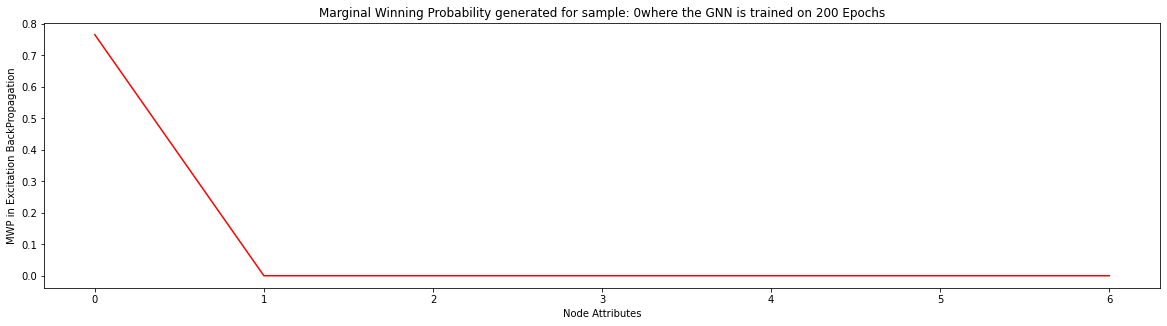

In [ ]:
Averaged_EB_one_graph = np.mean(EB, axis=0)
print(np.shape(Averaged_EB_one_graph))
MWP_Graph_Features(Averaged_EB_one_graph, 0)

## **Class based averaging on MWP**

In [ ]:
Graph_Index_Class1 = []
Graph_Index_Class2 = []

In [ ]:
for i in range(len(test_dataset)):
  if test_dataset[i].y == 0:
    Graph_Index_Class1.append(i)
  else:
    Graph_Index_Class2.append(i)

In [ ]:
print(len(Graph_Index_Class1), len(Graph_Index_Class2))
print(Graph_Index_Class1)
print(Graph_Index_Class2)

24 33
[4, 5, 6, 7, 12, 16, 21, 25, 26, 28, 29, 30, 31, 33, 36, 37, 39, 42, 50, 52, 53, 54, 55, 56]
[0, 1, 2, 3, 8, 9, 10, 11, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 27, 32, 34, 35, 38, 40, 41, 43, 44, 45, 46, 47, 48, 49, 51]


In [ ]:
EBs_Class1 = []
EBs_Class2 = []

## **MWPs of Graphs in each Class**

In [ ]:
for index in Graph_Index_Class1:
  EBs_Class1.append(EBs_Testset[index])
for index in Graph_Index_Class2:
  EBs_Class2.append(EBs_Testset[index])

In [ ]:
print(EBs_Class1)
print(EBs_Class2)
print(len(EBs_Class1))
print(len(EBs_Class2))
print(np.shape(EBs_Class1[0]))
print(np.shape(EBs_Class2[0]))

[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9999999999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[0.9999999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9999999999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.

## **Averaged MWPs on Node Features in all Graphs**

In [ ]:
EBs_Class1_Averaged_intra_Graph = []
EBs_Class2_Averaged_intra_Graph = []
for graph in EBs_Class1:
  EBs_Class1_Averaged_intra_Graph.append(np.mean(graph, axis=0).tolist())

for graph in EBs_Class2:
  EBs_Class2_Averaged_intra_Graph.append(np.mean(graph, axis=0).tolist())

In [ ]:
print(EBs_Class1_Averaged_intra_Graph)
print(EBs_Class2_Averaged_intra_Graph)
print(len(EBs_Class1_Averaged_intra_Graph))
print(len(EBs_Class2_Averaged_intra_Graph))
print(np.shape(EBs_Class1_Averaged_intra_Graph))
print(np.shape(EBs_Class2_Averaged_intra_Graph))

[[0.6470588235294118, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.45454545454545453, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.07692307692307693, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.27272727272727276, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.08333333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.5789473684210527, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.19047619047619047, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.1875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.5384615384615384, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.07692307692307694, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.3636363636363637, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.18181818181818185, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.5714285714285714, 0.0, 0.0, 0.0, 0.0, 0.0, 0

## **Averaged MWPs on Graphs in each Class**

In [ ]:
EBs_Class1_Averaged_intra_Class_Graphs = []
EBs_Class2_Averaged_intra_Class_Graphs = []
EBs_Class1_Averaged_intra_Class_Graphs = np.mean(EBs_Class1_Averaged_intra_Graph, axis=0)
EBs_Class2_Averaged_intra_Class_Graphs = np.mean(EBs_Class2_Averaged_intra_Graph, axis=0)

In [ ]:
print(EBs_Class1_Averaged_intra_Class_Graphs)

[0.21172313 0.         0.         0.         0.         0.
 0.        ]


## **PLOT Class-Wise Averaged MWPs **

In [ ]:
def Averaged_EBs_Intra_Classes(EB):
  fig1 = plt.figure(figsize=(20,40))

  ax1 = plt.subplot2grid((7, 1), (0, 0), colspan=7)
  plt.xlabel("Avg Graphs' MWPs")
  plt.ylabel('MWP in Excitation BackPropagation')
  plt.title("Marginal Winning Probability generated for Class: One, where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax2 = plt.subplot2grid((7, 1), (1, 0), colspan=7)
  plt.xlabel("Avg Graphs' MWPs")
  plt.ylabel('MWP in Excitation BackPropagation')
  plt.title("Marginal Winning Probability generated for Class: Two, where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax1.plot(EB[0], color='r')
  ax2.plot(EB[1], color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Dimensionally Averaged Excitations for Classes.png")
  plt.show()

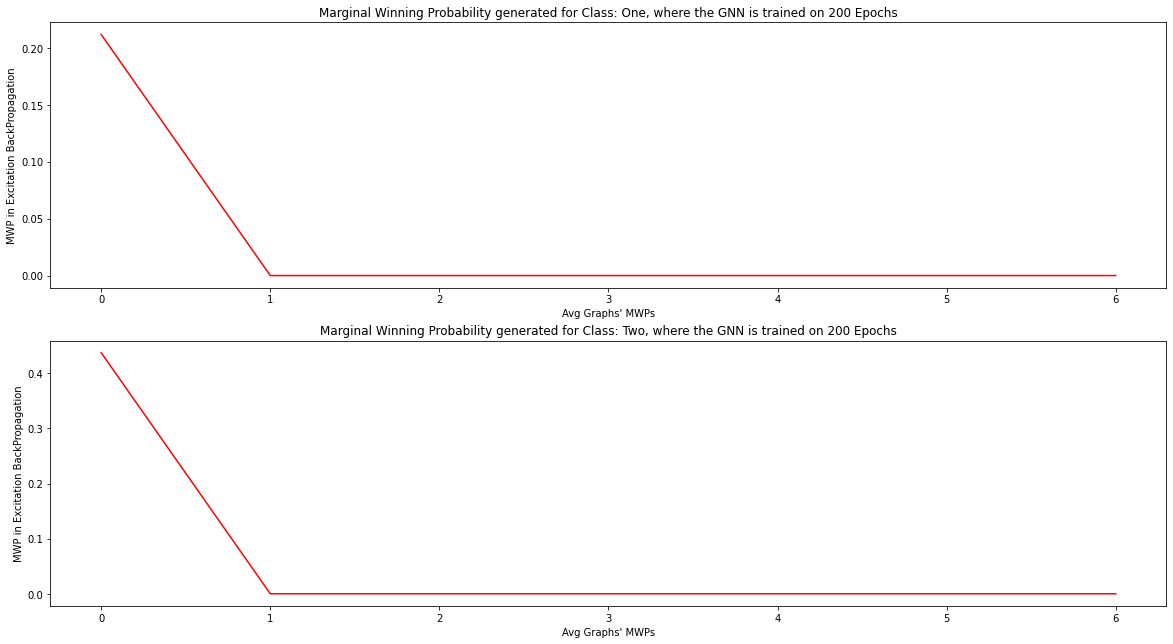

In [ ]:
Averaged_EBs_Intra_Classes([EBs_Class1_Averaged_intra_Class_Graphs, EBs_Class2_Averaged_intra_Class_Graphs])